## LSTM

In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dataset
from torch.autograd import Variable
from torch.nn import Parameter
from torch import Tensor
import torch.nn.functional as F
from torch.utils.data import DataLoader
import math

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

torch.manual_seed(125)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(125)

In [2]:
import torchvision.transforms as transforms

mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (1.0,))
])

In [3]:
from torchvision.datasets import MNIST

download_root = 'MNIST_DATASET/'

train_dataset = MNIST(download_root, transform=mnist_transform, train=True, download=True)
valid_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)
test_dataset = MNIST(download_root, transform=mnist_transform, train=False, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 239419708.64it/s]

Extracting MNIST_DATASET/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_DATASET/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 83197591.91it/s]


Extracting MNIST_DATASET/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_DATASET/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 71672467.40it/s]

Extracting MNIST_DATASET/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_DATASET/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19459171.37it/s]


Extracting MNIST_DATASET/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_DATASET/MNIST/raw



In [4]:
batch_size = 64
train_loader = DataLoader(dataset=train_dataset,
                         batch_size=batch_size,
                         shuffle=True)
valid_loader = DataLoader(dataset=valid_dataset,
                         batch_size=batch_size,
                         shuffle=True)
test_loader = DataLoader(dataset=test_dataset,
                         batch_size=batch_size,
                         shuffle=True)

In [10]:
batch_size = 100
n_iters = 6000
num_epochs = n_iters / (len(train_dataset) / batch_size)
num_epochs = int(num_epochs)

In [5]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias
        self.x2h = nn.Linear(input_size, 4 * hidden_size, bias=bias)
        self.h2h = nn.Linear(hidden_size, 4 * hidden_size, bias=bias)
        self.reset_parameters()

    def reset_parameters(self):
        std = 1.0 / math.sqrt(self.hidden_size)
        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, x, hidden):
        hx, cx = hidden
        x = x.view(-1, x.size(1))

        gates = self.x2h(x) + self.h2h(hx)
        gates = gates.squeeze()
        ingate, forgetgate, cellgate, outgate = gates.chunk(4, 1)

        ingate = F.sigmoid(ingate)
        forgetgate = F.sigmoid(forgetgate)
        cellgate = F.tanh(cellgate)
        outgate = F.sigmoid(outgate)

        cy = torch.mul(cx, forgetgate) +  torch.mul(ingate, cellgate)
        hy = torch.mul(outgate, F.tanh(cy))
        return (hy, cy)

In [6]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim, bias=True):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim

        self.layer_dim = layer_dim
        self.lstm = LSTMCell(input_dim, hidden_dim, layer_dim)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        if torch.cuda.is_available():
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
        else:
            h0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim))

        if torch.cuda.is_available():
            c0 = Variable(torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).cuda())
        else:
            c0 = Variable(torch.zeros(self.layer_dim, x.size(0), hidden_dim))

        outs = []
        cn = c0[0,:,:]
        hn = h0[0,:,:]

        for seq in range(x.size(1)):
            hn, cn = self.lstm(x[:,seq,:], (hn,cn))
            outs.append(hn)

        out = outs[-1].squeeze()
        out = self.fc(out)
        return out

In [7]:
input_dim = 28
hidden_dim = 128
layer_dim = 1
output_dim = 10

model = LSTMModel(input_dim, hidden_dim,layer_dim, output_dim)
if torch.cuda.is_available():
  model.cuda()

criterion = nn.CrossEntropyLoss()
learning_rate = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [11]:
seq_dim = 28
loss_list = []
iter = 0
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        if torch.cuda.is_available():
            images = Variable(images.view(-1, seq_dim, input_dim).cuda())
            labels = Variable(labels.cuda())
        else:
            images = Variable(images.view(-1, seq_dim, input_dim))
            labels = Variable(labels)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        if torch.cuda.is_available():
            loss.cuda()

        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        iter += 1

        if iter % 500 == 0:
            correct = 0
            total = 0
            for images, labels in valid_loader:
                if torch.cuda.is_available():
                    images = Variable(images.view(-1, seq_dim, input_dim).cuda())
                else:
                    images = Variable(images.view(-1 , seq_dim, input_dim))

                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)
                if torch.cuda.is_available():
                    correct += (predicted.cpu() == labels.cpu()).sum()
                else:
                    correct += (predicted == labels).sum()

            accuracy = 100 * correct / total
            print('Iteration: {}. Loss: {}. Accuracy: {}'.format(iter, loss.item(), accuracy))

Iteration: 500. Loss: 2.237457275390625. Accuracy: 21.420000076293945
Iteration: 1000. Loss: 0.9968994855880737. Accuracy: 74.94999694824219
Iteration: 1500. Loss: 0.42673957347869873. Accuracy: 88.13999938964844
Iteration: 2000. Loss: 0.30981600284576416. Accuracy: 93.56999969482422
Iteration: 2500. Loss: 0.0558248832821846. Accuracy: 95.69000244140625
Iteration: 3000. Loss: 0.09873700886964798. Accuracy: 95.58000183105469
Iteration: 3500. Loss: 0.08254366368055344. Accuracy: 96.8499984741211
Iteration: 4000. Loss: 0.03308983892202377. Accuracy: 97.08000183105469
Iteration: 4500. Loss: 0.049307383596897125. Accuracy: 97.08000183105469
Iteration: 5000. Loss: 0.08068697154521942. Accuracy: 96.69999694824219
Iteration: 5500. Loss: 0.12790139019489288. Accuracy: 97.30999755859375
Iteration: 6000. Loss: 0.007093742024153471. Accuracy: 97.66000366210938
Iteration: 6500. Loss: 0.011727366596460342. Accuracy: 97.63999938964844
Iteration: 7000. Loss: 0.008610538206994534. Accuracy: 98.06999969

In [12]:
def evaluate(model, val_iter):
    corrects, total, total_loss = 0, 0, 0
    model.eval()
    for images, labels in val_iter:
        if torch.cuda.is_available():
            images = Variable(images.view(-1, seq_dim, input_dim).cuda())
        else:
            images = Variable(images.view(-1 , seq_dim, input_dim)).to(device)
        labels = labels.cuda()
        logit = model(images).cuda()
        loss = F.cross_entropy(logit, labels, reduction = "sum")
        _, predicted = torch.max(logit.data, 1)
        total += labels.size(0)
        total_loss += loss.item()
        corrects += (predicted == labels).sum()

    avg_loss = total_loss / len(val_iter.dataset)
    avg_accuracy = corrects / total
    return avg_loss, avg_accuracy

In [13]:
test_loss, test_acc = evaluate(model, test_loader)
print("Test Loss: %5.2f | Test Accuracy: %5.2f" % (test_loss, test_acc))

Test Loss:  0.07 | Test Accuracy:  0.98


## 스타벅스 주가 예측

In [14]:
from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()

Saving SBUX.csv to SBUX.csv


In [15]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [16]:
device

device(type='cuda', index=0)

In [17]:
data = pd.read_csv('SBUX.csv')
print(data.dtypes)

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object


In [21]:
a = [i for i in data]
a

['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

In [22]:
from google.colab import files # 데이터 불러오기
file_uploaded=files.upload()
# SBUX_max

Saving SBUX_max.csv to SBUX_max.csv


In [23]:
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

In [24]:
data['Volume'] = data['Volume'].astype(float)

In [25]:
X=data.iloc[:,:-1]
y=data.iloc[:,5:6]
print(X)
print(y)

                  Open        High         Low       Close   Adj Close
Date                                                                  
2019-12-11   86.260002   86.870003   85.849998   86.589996   84.145752
2019-12-12   88.000000   88.889999   87.540001   88.209999   85.720032
2019-12-13   88.019997   88.790001   87.580002   88.669998   86.167046
2019-12-16   89.139999   89.300003   88.430000   88.779999   86.273941
2019-12-17   88.870003   88.970001   87.470001   88.129997   85.642288
...                ...         ...         ...         ...         ...
2020-12-04  101.349998  102.940002  101.070000  102.279999  101.442787
2020-12-07  102.010002  102.220001  100.690002  101.410004  100.579918
2020-12-08  100.370003  101.570000  100.010002  101.209999  100.381554
2020-12-09  101.940002  102.209999  100.099998  100.400002   99.578186
2020-12-10  103.510002  106.089996  102.750000  105.389999  104.527336

[253 rows x 5 columns]
                Volume
Date                  
2019-12

In [26]:
ms = MinMaxScaler()
ss = StandardScaler()

X_ss = ss.fit_transform(X)
y_ms = ms.fit_transform(y)

X_train = X_ss[:200, :]
X_test = X_ss[200:, :]

y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

print("Training Shape", X_train.shape, y_train.shape)
print("Testing Shape", X_test.shape, y_test.shape)

Training Shape (200, 5) (200, 1)
Testing Shape (53, 5) (53, 1)


In [27]:
X_train_tensors = Variable(torch.Tensor(X_train))
X_test_tensors = Variable(torch.Tensor(X_test))

y_train_tensors = Variable(torch.Tensor(y_train))
y_test_tensors = Variable(torch.Tensor(y_test))

X_train_tensors_f = torch.reshape(X_train_tensors,   (X_train_tensors.shape[0], 1, X_train_tensors.shape[1]))
X_test_tensors_f = torch.reshape(X_test_tensors,  (X_test_tensors.shape[0], 1, X_test_tensors.shape[1]))

print("Training Shape", X_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", X_test_tensors_f.shape, y_test_tensors.shape)

Training Shape torch.Size([200, 1, 5]) torch.Size([200, 1])
Testing Shape torch.Size([53, 1, 5]) torch.Size([53, 1])


In [28]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True)
        self.fc_1 =  nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)

        self.relu = nn.ReLU()

    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size))

        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

In [29]:
num_epochs = 1000
learning_rate = 0.0001

input_size = 5
hidden_size = 2
num_layers = 1

num_classes = 1
model = LSTM(num_classes, input_size, hidden_size, num_layers, X_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [30]:
for epoch in range(num_epochs):
    outputs = model.forward(X_train_tensors_f)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

Epoch: 0, loss: 0.18287
Epoch: 100, loss: 0.05713
Epoch: 200, loss: 0.03855
Epoch: 300, loss: 0.03717
Epoch: 400, loss: 0.03599
Epoch: 500, loss: 0.03326
Epoch: 600, loss: 0.02937
Epoch: 700, loss: 0.02517
Epoch: 800, loss: 0.02214
Epoch: 900, loss: 0.02043


In [31]:
df_x_ss = ss.transform(data.iloc[:, :-1])
df_y_ms = ms.transform(data.iloc[:, -1:])

df_x_ss = Variable(torch.Tensor(df_x_ss))
df_y_ms = Variable(torch.Tensor(df_y_ms))
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

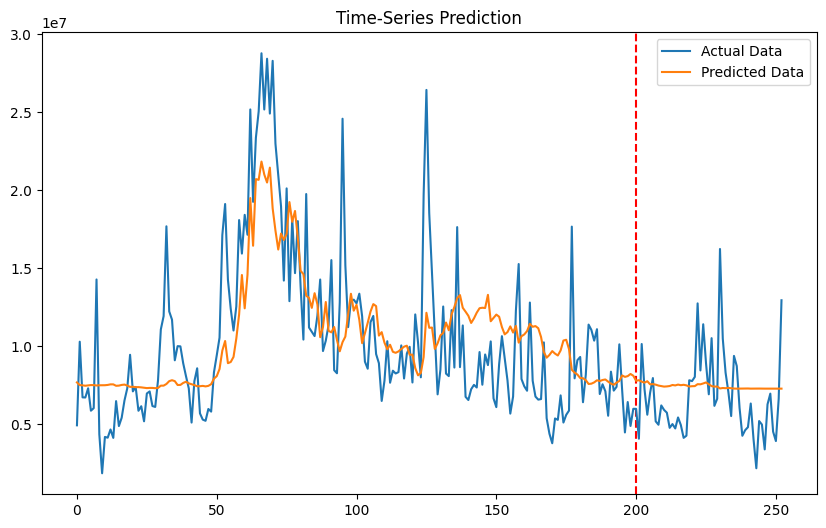

In [32]:
train_predict = model(df_x_ss)
predicted = train_predict.data.numpy()
label_y = df_y_ms.data.numpy()

predicted= ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10,6))
plt.axvline(x=200, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object
                 Open       High        Low      Close  Adj Close
Date                                                             
1992-06-26   0.328125   0.347656   0.320313   0.335938   0.265714
1992-06-29   0.339844   0.367188   0.332031   0.359375   0.284252
1992-06-30   0.367188   0.371094   0.343750   0.347656   0.274982
1992-07-01   0.351563   0.359375   0.339844   0.355469   0.281162
1992-07-02   0.359375   0.359375   0.347656   0.355469   0.281162
...               ...        ...        ...        ...        ...
2023-08-17  99.000000  99.099998  96.430000  96.570000  96.570000
2023-08-18  96.010002  97.489998  95.790001  97.230003  97.230003
2023-08-21  97.320000  97.570000  96.160004  96.459999  96.459999
2023-08-22  96.489998  96.739998  95.599998  96.070000  96.070000
2023-08-23  96.419998  96.559998  94.010002  95

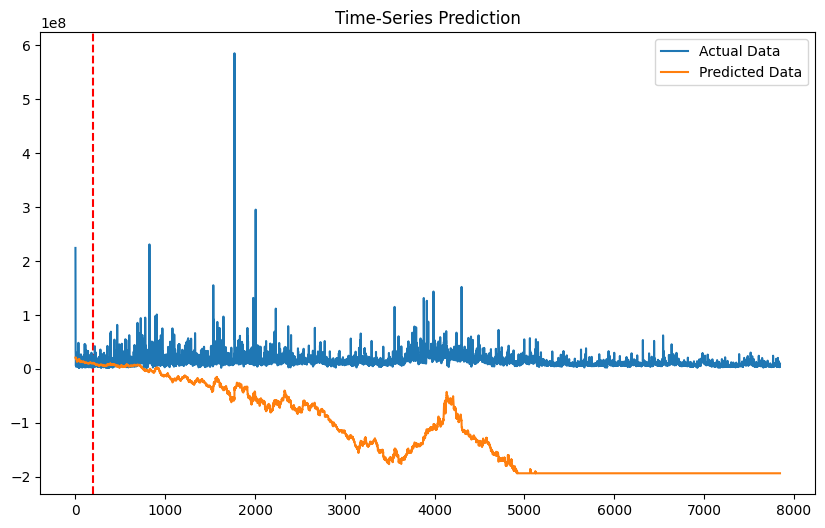

In [45]:
import os
import time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Check if CUDA is available and set the device accordingly
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

data = pd.read_csv('SBUX_max.csv')
print(data.dtypes)

data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

data['Volume'] = data['Volume'].astype(float)

x = data.iloc[:, :-1]
y = data.iloc[:, 5:6]
print(x)
print(y)

ms = MinMaxScaler()
ss = StandardScaler()

x_ss = ss.fit_transform(x)
y_ms = ms.fit_transform(y)

x_train = x_ss[:200, :]
x_test = x_ss[200:, :]

y_train = y_ms[:200, :]
y_test = y_ms[200:, :]

print("Training Shape", x_train.shape, y_train.shape)
print("Testing Shape", x_test.shape, y_test.shape)

# Convert data to tensors and move to the appropriate device
x_train_tensors = Variable(torch.Tensor(x_train)).to(device)
x_test_tensors = Variable(torch.Tensor(x_test)).to(device)

y_train_tensors = Variable(torch.Tensor(y_train)).to(device)
y_test_tensors = Variable(torch.Tensor(y_test)).to(device)

x_train_tensors_f = torch.reshape(x_train_tensors, (x_train_tensors.shape[0], 1, x_train_tensors.shape[1]))
x_test_tensors_f = torch.reshape(x_test_tensors, (x_test_tensors.shape[0], 1, x_test_tensors.shape[1]))

print("Training Shape", x_train_tensors_f.shape, y_train_tensors.shape)
print("Testing Shape", x_test_tensors_f.shape, y_test_tensors.shape)

class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(LSTM, self).__init__()
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 128)
        self.fc = nn.Linear(128, num_classes)

        self.relu = nn.ReLU()

    def forward(self, x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device)

        output, (hn, cn) = self.lstm(x, (h_0, c_0))
        hn = hn.view(-1, self.hidden_size)
        out = self.relu(hn)
        out = self.fc_1(out)
        out = self.relu(out)
        out = self.fc(out)
        return out

# Variable values
num_epochs = 20000
learning_rate = 0.0001

input_size = 5
hidden_size = 2
num_layers = 1

num_classes = 1
model = LSTM(num_classes, input_size, hidden_size, num_layers, x_train_tensors_f.shape[1])

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model = model.to(device)
criterion = criterion.to(device)

# Model training
for epoch in range(num_epochs):
    outputs = model.forward(x_train_tensors_f)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_tensors)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print("Epoch: %d, loss: %1.5f" % (epoch, loss.item()))

df_x_ss = ss.transform(data.iloc[:, :-1])
df_y_ms = ms.transform(data.iloc[:, -1:])

df_x_ss = Variable(torch.Tensor(df_x_ss)).to(device)
df_y_ms = Variable(torch.Tensor(df_y_ms)).to(device)
df_x_ss = torch.reshape(df_x_ss, (df_x_ss.shape[0], 1, df_x_ss.shape[1]))

# Model prediction and visualization
train_predict = model(df_x_ss)
predicted = train_predict.data.cpu().numpy()
label_y = df_y_ms.data.cpu().numpy()

predicted = ms.inverse_transform(predicted)
label_y = ms.inverse_transform(label_y)
plt.figure(figsize=(10, 6))
plt.axvline(x=200, c='r', linestyle='--')

plt.plot(label_y, label='Actual Data')
plt.plot(predicted, label='Predicted Data')
plt.title('Time-Series Prediction')
plt.legend()
plt.show()

😱